## Programming Exercise 7: _K_-means Clustering and Principal Component Analysis

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
from random import sample #Used for random initialization
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
from scipy import linalg #Used for the "SVD" function

### 1 _K_-means Clustering
#### 1.1 Implementing _K_-means
##### 1.1.1 Finding closest centroids

In [14]:
#Read in ex7data2.mac
datafile = 'data/ex7data2.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

#X is 300 points, each has two coordinates
#IE the shape is (300,2)

In [15]:
#Choose the number of centroids... K = 3
K = 3
#Choose the initial centroids matching ex7.m assignment script
initial_centroids = np.array([[3,3],[6,2],[8,5]])

In [16]:
#Visualizing the data
def plotData(myX,mycentroids,myidxs = None):

    """
    Fucntion to plot the data and color it accordingly.
    myidxs should be the latest iteraction index vector
    mycentroids should be a vector of centroids, one per iteration
    """
    
    colors = ['b','g','gold','darkorange','salmon','olivedrab']
    
    assert myX[0].shape == mycentroids[0][0].shape
    assert mycentroids[-1].shape[0] <= len(colors)

    #If idxs is supplied, divide up X into colors
    if myidxs is not None:
        assert myidxs.shape[0] == myX.shape[0]
        subX = []
        for x in range(mycentroids[0].shape[0]):
            subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    else:
        subX = [myX]
        
    fig = plt.figure(figsize=(7,5))
    for x in range(len(subX)):
        newX = subX[x]
        plt.plot(newX[:,0],newX[:,1],'o',color=colors[x],
                 alpha=0.75, label='Data Points: Cluster %d'%x)
    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.title('Plot of X Points',fontsize=16)
    plt.grid(True)

    #Drawing a history of centroid movement
    tempx, tempy = [], []
    for mycentroid in mycentroids:
        tempx.append(mycentroid[:,0])
        tempy.append(mycentroid[:,1])
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'rx--', markersize=8)

    leg = plt.legend(loc=4, framealpha=0.5)

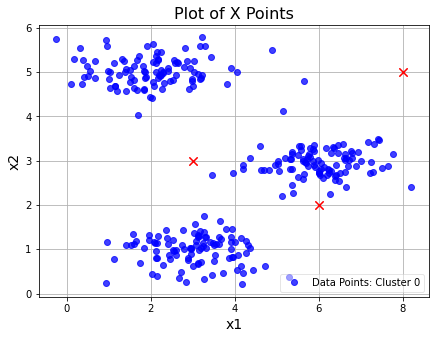

In [17]:
plotData(X,[initial_centroids])

In [18]:
def distSquared(point1, point2):
    assert point1.shape == point2.shape
    return np.sum(np.square(point2-point1))

In [19]:
def findClosestCentroids(myX, mycentroids):
    """
    Function takes in the (m,n) X matrix
    (where m is the # of points, n is # of features per point)
    and the (K,n) centroid seed matrix
    (where K is the # of centroids (clusters)
    and returns a (m,1) vector of cluster indices 
    per point in X (0 through K-1)
    """
    idxs = np.zeros((myX.shape[0],1))
    
    #Loop through each data point in X
    for x in range(idxs.shape[0]):
        mypoint = myX[x]
        #Compare this point to each centroid,
        #Keep track of shortest distance and index of shortest distance
        mindist, idx = 9999999, 0
        for i in range(mycentroids.shape[0]):
            mycentroid = mycentroids[i]
            distsquared = distSquared(mycentroid,mypoint)
            if distsquared < mindist:
                mindist = distsquared
                idx = i
        #With the best index found, modify the result idx vector
        idxs[x] = idx
        
    return idxs

In [20]:
idxs = findClosestCentroids(X,initial_centroids)

#you should see the output [1 3 2] corresponding to the 
#centroid assignments for the first 3 examples.
#Note my indices start at 0, so I should see [0, 2, 1]
print (idxs[:3].flatten())

[0. 2. 1.]


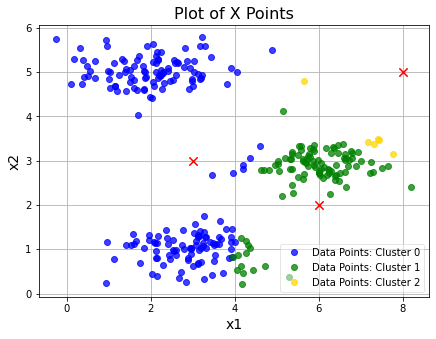

In [21]:
plotData(X,[initial_centroids],idxs)

##### 1.1.2 Computing centroid means

In [22]:
def computeCentroids(myX, myidxs):
    """
    Function takes in the X matrix and the index vector
    and computes a new centroid matrix.
    """
    subX = []
    for x in range(len(np.unique(myidxs))):
        subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    return np.array([np.mean(thisX,axis=0) for thisX in subX])

#### 1.2 _K_-means on example dataset

In [23]:
def runKMeans(myX, initial_centroids, K, n_iter):
    """
    Function that actually does the iterations
    """
    centroid_history = []
    current_centroids = initial_centroids
    for myiter in range(n_iter):
        centroid_history.append(current_centroids)
        idxs = findClosestCentroids(myX,current_centroids)
        current_centroids = computeCentroids(myX,idxs)
        
    return idxs, centroid_history

In [24]:
idxs, centroid_history = runKMeans(X,initial_centroids,K=3,n_iter=10)

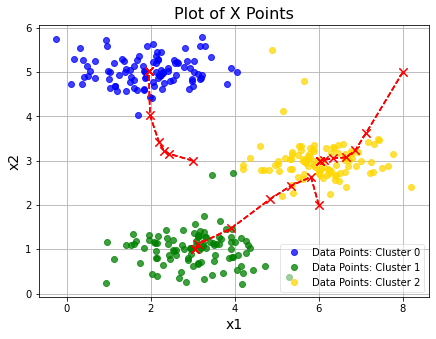

In [25]:
plotData(X,centroid_history,idxs)

#### 1.3 Random initialization

In [26]:
def chooseKRandomCentroids(myX, K):
    rand_indices = sample(range(0,myX.shape[0]),K)
    return np.array([myX[i] for i in rand_indices])    

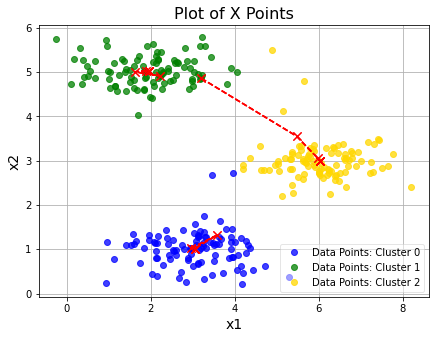

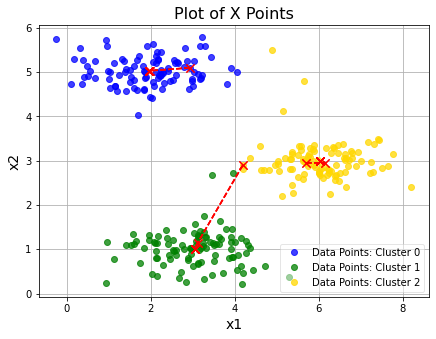

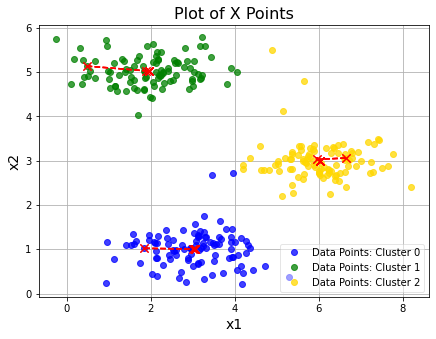

In [27]:
#Let's choose random initial centroids and see the resulting 
#centroid progression plot.. perhaps three times in a row
for x in range(3):
    idxs, centroid_history = runKMeans(X,chooseKRandomCentroids(X,K=3),
                                       K=3,n_iter=10)
    plotData(X,centroid_history,idxs)

#### 1.4 Image compression with _K_-means
##### 1.4.1 _K_-means on pixels

A shape is  (128, 128, 3)


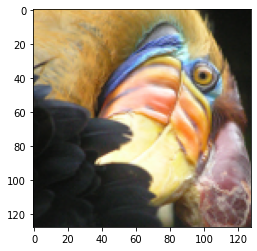

In [29]:
datafile = 'data/bird_small.png'
import imageio
# This creates a three-dimensional matrix A whose first two indices 
# identify a pixel position and whose last index represents red, green, or blue.
A = imageio.v3.imread(datafile)

print ("A shape is ",A.shape)
dummy = plt.imshow(A)

In [30]:
# Divide every entry in A by 255 so all values are in the range of 0 to 1
A = A / 255.

# Unroll the image to shape (16384,3) (16384 is 128*128)
A = A.reshape(-1, 3)

# Run k-means on this data, forming 16 clusters, with random initialization
myK = 16
idxs, centroid_history = runKMeans(A,chooseKRandomCentroids(A,myK),
                                   myK,n_iter=10)

In [31]:
# Now I have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating
# which of the 16 colors it should be
idxs = findClosestCentroids(A, centroid_history[-1])

In [32]:
final_centroids = centroid_history[-1]
# Now loop through the original image and form a new image
# that only has 16 colors in it
final_image = np.zeros((idxs.shape[0],3))
for x in range(final_image.shape[0]):
    final_image[x] = final_centroids[int(idxs[x])]

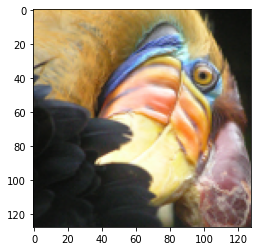

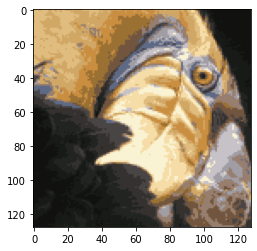

In [33]:
# Reshape the original image and the new, final image and draw them
# To see what the "compressed" image looks like
plt.figure()
dummy = plt.imshow(A.reshape(128,128,3))
plt.figure()
dummy = plt.imshow(final_image.reshape(128,128,3))

### 2 Principal Component Analysis
#### 2.1 Example Dataset

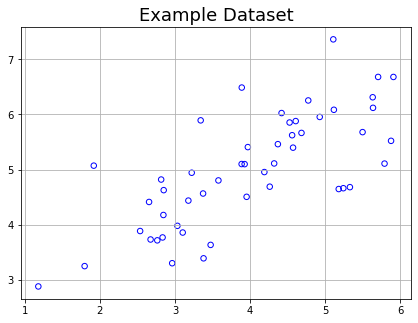

In [189]:
datafile = 'data/ex7data1.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

#Quick plot
plt.figure(figsize=(7,5))
plot = plt.scatter(X[:,0], X[:,1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset",fontsize=18)
plt.grid(True)

#### 2.2 Implementing PCA

In [190]:
def featureNormalize(myX):
    #Feature-normalize X, return it
    means = np.mean(myX,axis=0)
    myX_norm = myX - means
    stds  = np.std(myX_norm,axis=0)
    myX_norm = myX_norm / stds
    return means, stds, myX_norm

In [191]:
def getUSV(myX_norm):
    # Compute the covariance matrix
    cov_matrix = myX_norm.T.dot(myX_norm)/myX_norm.shape[0]
    # Run single value decomposition to get the U principal component matrix
    U, S, V = scipy.linalg.svd(cov_matrix, full_matrices = True, compute_uv = True)
    return U, S, V

In [192]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = getUSV(X_norm)

Top principal component is  [-0.70710678 -0.70710678]


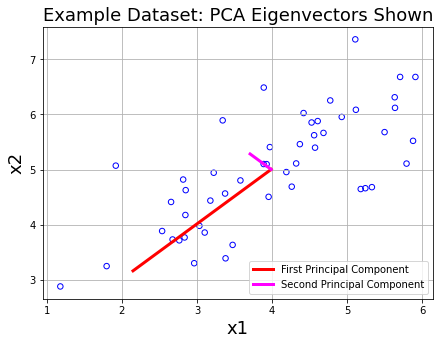

In [194]:
# "...output the top principal component (eigen- vector) found, 
# and you should expect to see an output of about [-0.707 -0.707]"
print ('Top principal component is ',U[:,0])

#Quick plot, now including the principal component
plt.figure(figsize=(7,5))
plot = plt.scatter(X[:,0], X[:,1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset: PCA Eigenvectors Shown",fontsize=18)
plt.xlabel('x1',fontsize=18)
plt.ylabel('x2',fontsize=18)
plt.grid(True)
#To draw the principal component, you draw them starting
#at the mean of the data
plt.plot([means[0], means[0] + 1.5*S[0]*U[0,0]], 
         [means[1], means[1] + 1.5*S[0]*U[0,1]],
        color='red',linewidth=3,
        label='First Principal Component')
plt.plot([means[0], means[0] + 1.5*S[1]*U[1,0]], 
         [means[1], means[1] + 1.5*S[1]*U[1,1]],
        color='fuchsia',linewidth=3,
        label='Second Principal Component')
leg = plt.legend(loc=4)

#### 2.3 Dimensionality Reduction with PCA
##### 2.3.1 Projecting the data onto the principal components

In [195]:
def projectData(myX, myU, K):
    """
    Function that computes the reduced data representation when
    projecting only on to the top "K" eigenvectors
    """
    
    #Reduced U is the first "K" columns in U
    Ureduced = myU[:,:K]
    z = myX.dot(Ureduced)
    return z

In [196]:
# "...project the first example onto the first dimension 
# "and you should see a value of about 1.481"
z = projectData(X_norm,U,1)
print ('Projection of the first example is %0.3f.'%float(z[0]))

Projection of the first example is 1.496.


##### 2.3.2 Reconstructing an approximation of the data

In [197]:
def recoverData(myZ, myU, K):
    Ureduced = myU[:,:K]
    Xapprox = myZ.dot(Ureduced.T)  
    return Xapprox

In [198]:
X_rec = recoverData(z,U,1)
print ('Recovered approximation of the first example is ',X_rec[0])

Recovered approximation of the first example is  [-1.05805279 -1.05805279]


##### 2.3.3 Visualizing the projections

In [235]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(X_norm)

PCA(n_components=1)

In [230]:
pca.transform(X_norm).shape

(50, 2)

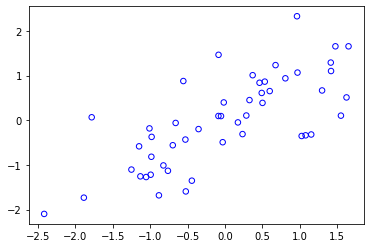

In [232]:
plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', edgecolors='b')

In [249]:
X_rec_ = np.dot(pca.transform(X_norm),pca.components_)

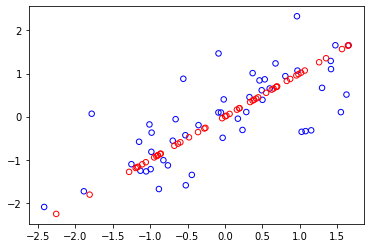

In [250]:
plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', edgecolors='b')
# X_rec_ = np.matmul(pca.transform(X_norm),X_norm) + X_norm.mean()
plt.scatter(X_rec_[:,0], X_rec_[:,1], s=30, facecolors='none', edgecolors='r')

In [227]:
X_norm.shape

(50, 2)

In [244]:
X_rec = X_rec_

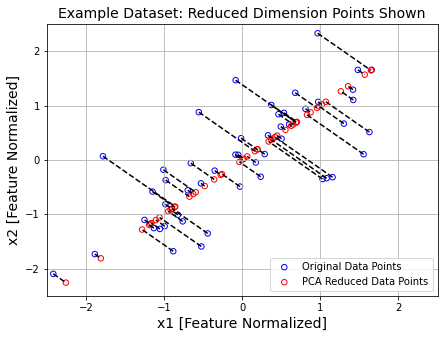

In [245]:
#Quick plot, now drawing projected points to the original points
plt.figure(figsize=(7,5))
plot = plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', 
                   edgecolors='b',label='Original Data Points')
plot = plt.scatter(X_rec[:,0], X_rec[:,1], s=30, facecolors='none', 
                   edgecolors='r',label='PCA Reduced Data Points')

plt.title("Example Dataset: Reduced Dimension Points Shown",fontsize=14)
plt.xlabel('x1 [Feature Normalized]',fontsize=14)
plt.ylabel('x2 [Feature Normalized]',fontsize=14)
plt.grid(True)

for x in range(X_norm.shape[0]):
    plt.plot([X_norm[x,0],X_rec[x,0]],[X_norm[x,1],X_rec[x,1]],'k--')
    
leg = plt.legend(loc=4)

#Force square axes to make projections look better
dummy = plt.xlim((-2.5,2.5))
dummy = plt.ylim((-2.5,2.5))

#### 2.4 Face Image Dataset

In [251]:
datafile = 'data/ex7faces.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

In [252]:
X.shape

(5000, 1024)

In [253]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x1032,
    crates an image object from it, and returns it
    """
    width, height = 32, 32
    square = row.reshape(width,height)
    return square.T
    
def displayData(myX, mynrows = 10, myncols = 10):
    """
    Function that picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 32, 32
    nrows, ncols = mynrows, myncols

    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in range(nrows*ncols):
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(myX[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(10,10))
    # img = scipy.misc.toimage( big_picture )
    plt.imshow(big_picture,cmap = cm.Greys_r)

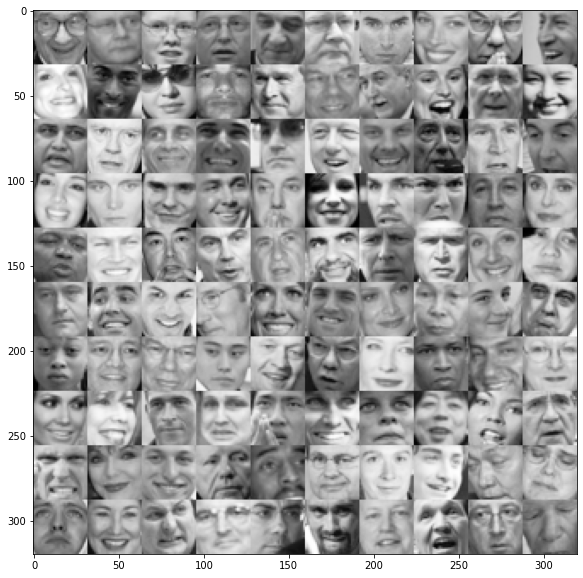

In [254]:
displayData(X)

##### 2.4.1 PCA on Faces

In [255]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = getUSV(X_norm)

In [292]:
from sklearn.decomposition import PCA
pca = PCA(n_components=36)
pca.fit(X_norm)

PCA(n_components=36)

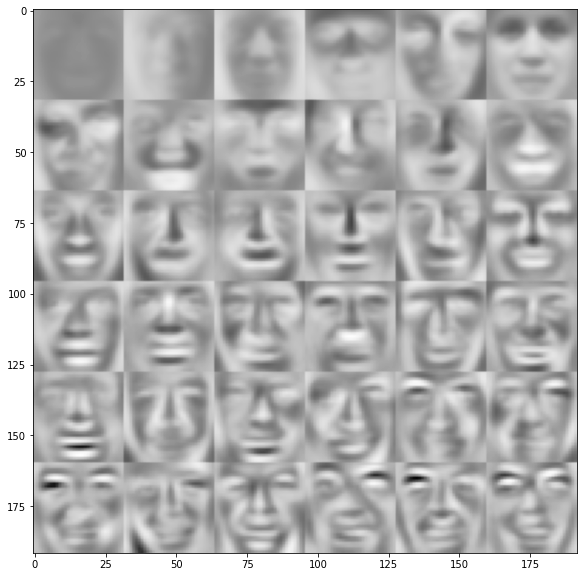

In [288]:
displayData(pca.components_,mynrows=6,myncols=6)

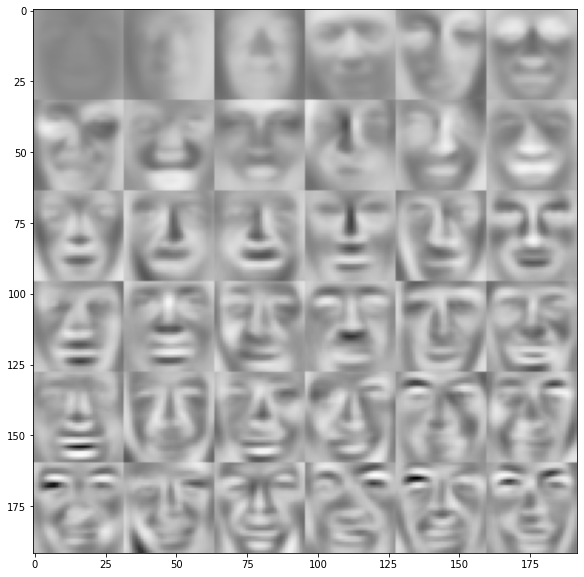

In [263]:
# Visualize the top 36 eigenvectors found
# "Eigenfaces" lol
displayData(U[:,:36].T,mynrows=6,myncols=6)

##### 2.4.2 Dimensionality Reduction

In [293]:
z = pca.transform(X_norm)
X_rec = np.dot(z,pca.components_)

In [299]:
np.dot(z,pca.components_),'\n\n', X_rec

(array([[-0.36880453, -0.37781347, -0.37868138, ..., -0.62884855,
         -0.55380641, -0.47445117],
        [ 0.20880048,  0.20687791,  0.18790752, ..., -0.5633209 ,
         -0.5254822 , -0.47275321],
        [ 0.30242021,  0.26972449,  0.26963235, ..., -0.90978528,
         -0.91427401, -0.90703853],
        ...,
        [-0.25295845, -0.24754721, -0.20639943, ...,  1.67563768,
          1.6284934 ,  1.54719316],
        [ 0.58162102,  0.63762908,  0.67838711, ..., -0.18804173,
         -0.11462451, -0.07344788],
        [-1.59836829, -1.65486553, -1.70486496, ...,  0.70980916,
          0.68667358,  0.64661854]]),
 '\n\n',
 array([[-0.36880453, -0.37781347, -0.37868138, ..., -0.62884855,
         -0.55380641, -0.47445117],
        [ 0.20880048,  0.20687791,  0.18790752, ..., -0.5633209 ,
         -0.5254822 , -0.47275321],
        [ 0.30242021,  0.26972449,  0.26963235, ..., -0.90978528,
         -0.91427401, -0.90703853],
        ...,
        [-0.25295845, -0.24754721, -0.2063994

In [289]:
# Project each image down to 36 dimensions
z = projectData(X_norm, U, K=36)

In [290]:
# Attempt to recover the original data
X_rec = recoverData(z, U, K=36)

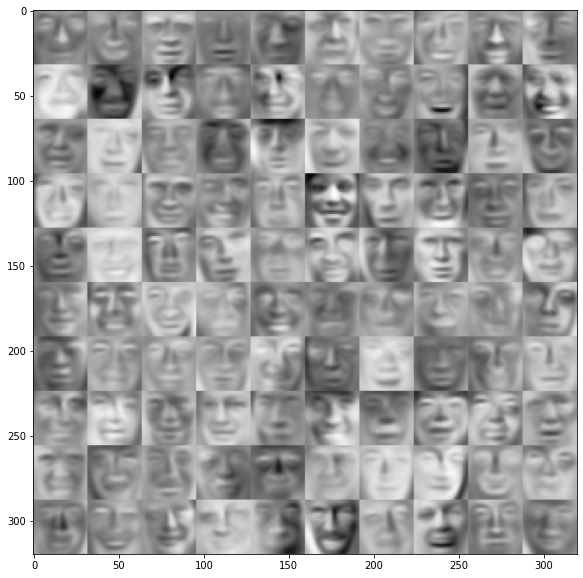

In [294]:
# Plot the dimension-reduced data
displayData(X_rec)

#### 2.5 Optional: PCA for visualization

In [301]:
A.shape

(16384, 3)

In [302]:
# Here we display the 16 color clusters from before in 2D because a 3D
# display (r, g, b) is too cumbersome to look at.
# PCA projects the 3D into 2D to visualize.

# Recall "A" is the original image unrolled, shape (16384, 3)
# and "idxs" is shape (16384, 1) with entries in [0, 15]
#Feature-normalize A, save it as A_norm
# Feature normalize
means, stds, A_norm = featureNormalize(A)
# Run SVD
U, S, V = getUSV(A_norm)

In [303]:
# Use PCA to go from 3->2 dimensions
z = projectData(A_norm,U,2)

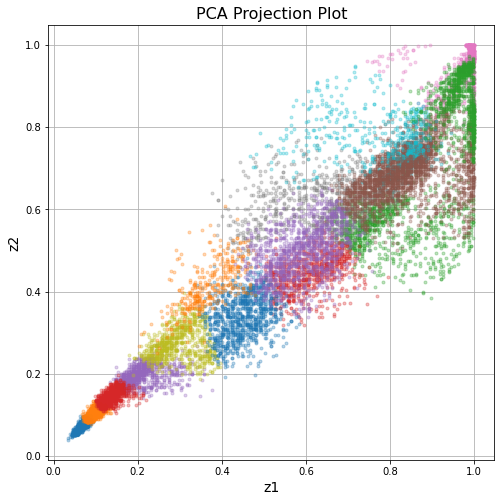

In [323]:
# Make the 2D plot
subX = []
for x in range(len(np.unique(idxs))):
    subX.append(np.array([A[i] for i in range(A.shape[0]) if idxs[i] == x]))
        
fig = plt.figure(figsize=(8,8))
for x in range(len(subX)):
    newX = subX[x]
    plt.plot(newX[:,0],newX[:,1],'.',alpha=0.3)
plt.xlabel('z1',fontsize=14)
plt.ylabel('z2',fontsize=14)
plt.title('PCA Projection Plot',fontsize=16)
plt.grid(True)

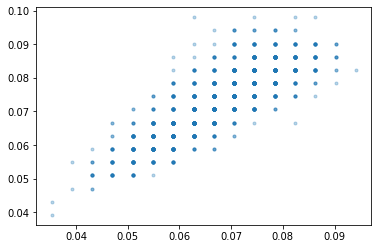

In [333]:
for x in range(len(subX)):
    newX = subX[x]
    plt.plot(newX[:,0],newX[:,1],'.',alpha=0.3)
    break

In [329]:
newX[:,0].shape

(1418,)

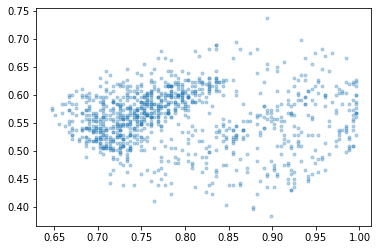

In [337]:
plt.plot(subX[2][:,0],subX[2][:,1],'.',alpha=0.3)

In [322]:
subX[0][:,0].shape

(1418,)